## Cross-Shelf Transport - Diffusivity effects

This notebook explores the effects of changing the diapycnal diffusivity on the cross-shelf transport of tracers .

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Exp
#CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridNoCOut = Dataset(CGridNoC)


In [52]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 13 # number of tracers in total (CNT =9, 3D = 4, total = 13)

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

labels = ['Kv_in=1E-7, Kv_out=1E-3','Kv_in=1E-7, Kv_out=1E-4','Kv_in=1E-5, Kv_out=1E-3',
          'Kv_in=1E-5, Kv_out=1E-4','Kv=1E-5','Kv=1E-4','Kv=1E-3','Kv=3.8E-5','Kv=2.8E-5','Kv=1.3E-5','Kv_noc=1E-5','Kv_noc=1E-4','Kv_noc=1E-3']

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [6]:
def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [7]:
# Just to know what's in there...
df = pd.read_csv('results/metricsDataFrames/CNTDIFF_CSTRANS_run03Tr2.csv')
df.head(1)

,Unnamed: 0,day,CS1,CS2,CS3,CS3sb,CS4,CS5,AS1,AS2,LID1,LID2
0,0,0.5,-0.255313,-0.684843,6.053521,0.585201,-4.643782,-0.226209,31.498585,37.769226,0.10978,0.540488


In [8]:
# load initial profiles

tracers_3D = ['04','05','06','07'] #run number because there's only 1 tr per run
tracers_CNT03 = ['1','2','3'] # tracer number , constant runs
tracers_CNT09 = ['1','2','3'] # tracer number , average diffusivity runs
tracers_CNT07 = ['1','2','3'] # tracer number , no canyon case

CS1 = np.zeros((nt-1,numTr)) 
CS2 = np.zeros((nt-1,numTr)) 
CS3 = np.zeros((nt-1,numTr)) 
CS4 = np.zeros((nt-1,numTr)) 
CS5 = np.zeros((nt-1,numTr)) 
CS3sb = np.zeros((nt-1,numTr)) 
AS1 = np.zeros((nt-1,numTr)) 
AS2 = np.zeros((nt-1,numTr)) 
LID1 = np.zeros((nt-1,numTr)) 
LID2 = np.zeros((nt-1,numTr)) 

kk = 0

fields = ['CS1','CS2','CS3','CS3sb','CS4','CS5','AS1' ,'AS2','LID1' ,'LID2']

for ii in tracers_3D:
    
    CS1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[0] )
    CS2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[1] )
    CS3[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[2] )
    CS3sb[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[3] )
    CS4[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[4] )
    CS5[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[5] )
    AS1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[6] )
    AS2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[7] )
    LID1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[8] )
    LID2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[9] )
      
    kk=kk+1

for ii in tracers_CNT03:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[9] )
      
    kk=kk+1

for ii in tracers_CNT09:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[9] )
      
    kk=kk+1

for ii in tracers_CNT07:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[9] )
      
    kk=kk+1

print(kk)

13


## Definition of sections 

Different sections are defined to cover the whole shelf, and transports are sliced across them. There is  ane xtra section, not shown below, parallel to CS3 but leveled with the shelf break if the shelf was flat (yc[227,x]). It is named CS3sb.

<img src="figs/CrossShelfPlanes.png">

### Changing constant diffusivity without canyon

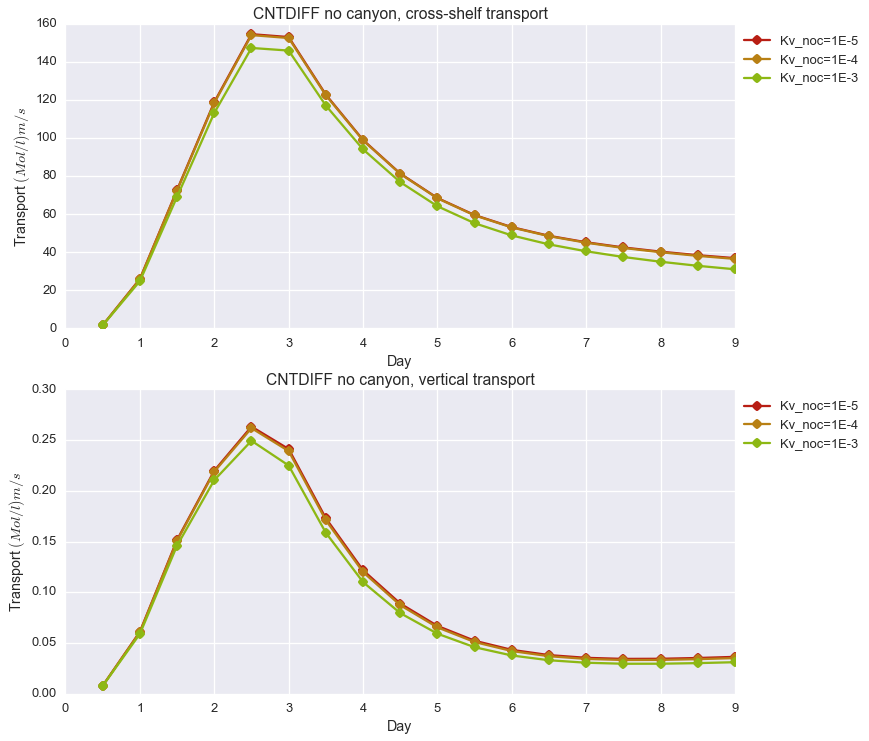

In [24]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,4] + LID2[:,4] 
total1 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3sb[:,4] + CS4[:,4] + CS5[:,4]
vertical2 =LID1[:,11] + LID2[:,11] 
total2 = - AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3sb[:,11] + CS4[:,11] + CS5[:,11]
vertical3 =LID1[:,6] + LID2[:,6] 
total3 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3sb[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[10])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[12])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, cross-shelf transport')


ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[10])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[12])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, vertical transport')

#fig45.savefig('results/figures/CStransport/CSTransportCNTNoC_3Tr_difference.eps', format='eps', dpi=1000, bbox_inches='tight')


### Relative magnitude of each transect's transport w.r.t. no canyon case.

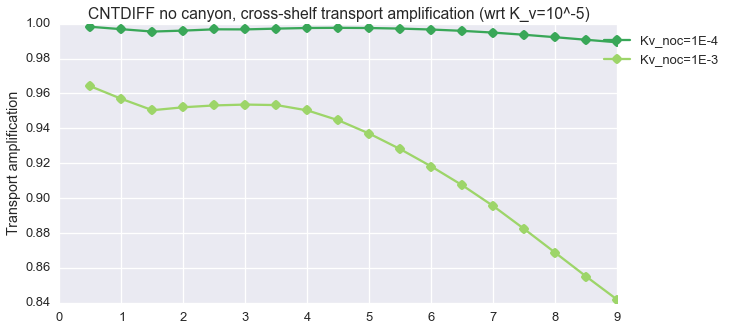

In [54]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((2,2))

fig45=plt.figure(figsize=(10,5))

vertical1 =LID1[:,10] + LID2[:,10] 
total1 =  - AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3sb[:,10] + CS4[:,10] + CS5[:,10]
vertical2 =LID1[:,11] + LID2[:,11] 
total2 = - AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3sb[:,11] + CS4[:,11] + CS5[:,11]
vertical3 =LID1[:,12] + LID2[:,12] 
total3 = - AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3sb[:,12] + CS4[:,12] + CS5[:,12]

ax1 = plt.subplot(1,1,1)
ax1.plot(times[1:]/2.0, total2/total1,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, total3/total1,'o-', label = labels[12])

means[0,0] = np.mean(total2[:10]/total1[:10])
means[1,0] = np.mean(total3[:10]/total1[:10])
means[0,1] = np.std(total2[10:]/total1[10:])
means[1,1] = np.std(total3[10:]/total1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF no canyon, cross-shelf transport amplification (wrt K_v=10^-5)')


#fig45.savefig('results/figures/CStransport/CSTransportCNTNoC_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [55]:
means





array([[ 0.99699926,  0.0026677 ],
       [ 0.95153757,  0.02867978]])

### Canyon case - changing vertical diffusivity

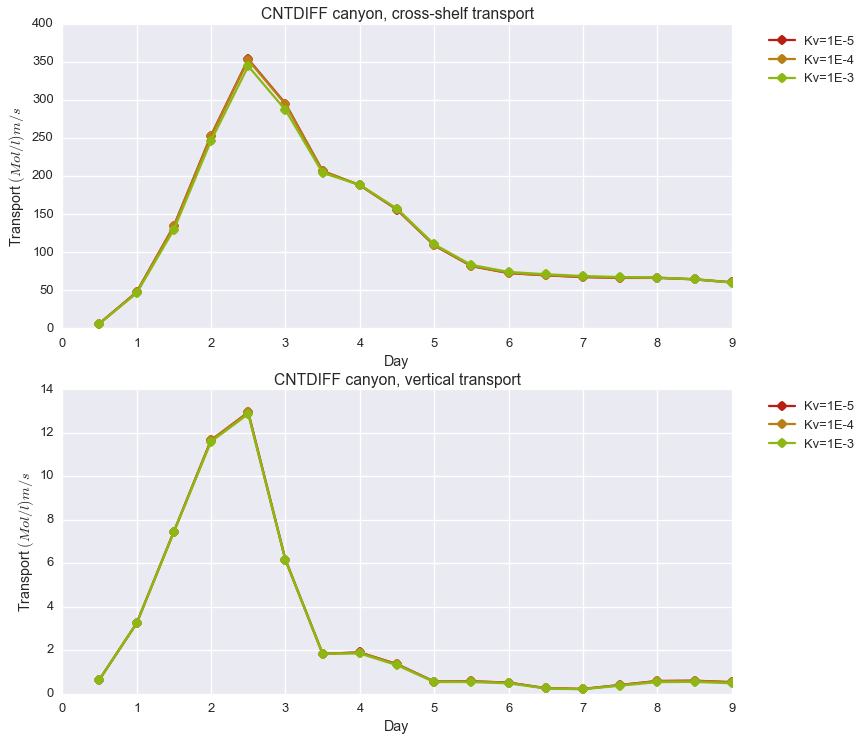

In [53]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,4] + LID2[:,4] 
total1 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical2 =LID1[:,5] + LID2[:,5] 
total2 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical3 =LID1[:,6] + LID2[:,6] 
total3 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, cross-shelf transport')


ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[6])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, vertical transport')

#fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_difference.eps', format='eps', dpi=1000, bbox_inches='tight')


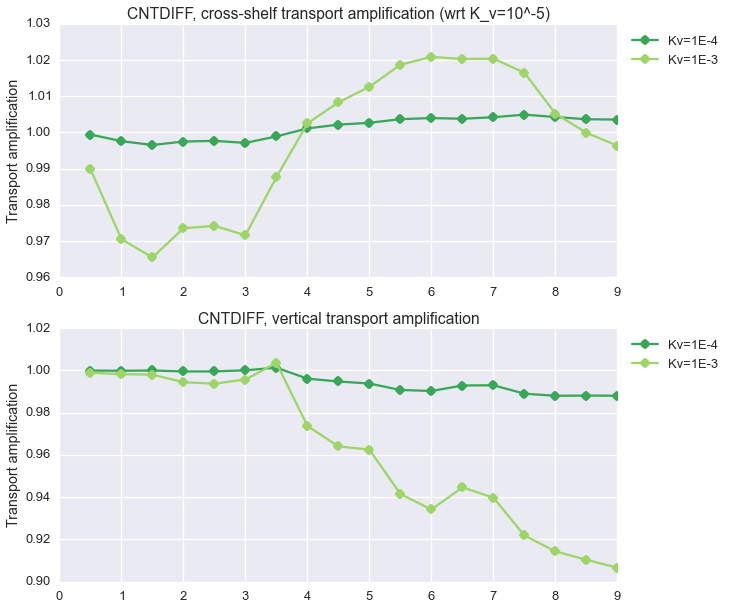

In [58]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((4,2))

fig45=plt.figure(figsize=(10,10))

vertical1 =LID1[:,4] + LID2[:,4] 
total1 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical2 =LID1[:,5] + LID2[:,5] 
total2 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical3 =LID1[:,6] + LID2[:,6] 
total3 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total2/total1,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3/total1,'o-', label = labels[6])

means[0,0] = np.mean(total2[:10]/total1[:10])
means[1,0] = np.mean(total3[:10]/total1[:10])
means[0,1] = np.std(total2[10:]/total1[10:])
means[1,1] = np.std(total3[10:]/total1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF, cross-shelf transport amplification (wrt K_v=10^-5)')

ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical2/vertical1,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical3/vertical1,'o-', label = labels[6])

means[2,0] = np.mean(vertical2[:10]/vertical1[:10])
means[3,0] = np.mean(vertical3[:10]/vertical1[:10])
means[2,1] = np.std(vertical2[10:]/vertical1[10:])
means[3,1] = np.std(vertical3[10:]/vertical1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF, vertical transport amplification ')


fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [59]:
means

array([[  9.99057146e-01,   4.24269904e-04],
       [  9.85628946e-01,   9.47966554e-03],
       [  9.98438924e-01,   1.94202938e-03],
       [  9.88246286e-01,   1.41942762e-02]])